In [21]:
import QUANTAXIS as QA
import datetime
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
import quantaxis_ext
from talib import MA_Type
import talib
import jupyter_helper
import calculator
import os
from tqdm import tqdm_notebook
import simulate
from pyecharts import Line
#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
%config InlineBackend.figure_format = 'svg'

In [22]:
zs_code = jupyter_helper.get_zs_code()
'指数代码:{0}'.format(zs_code)

start_date, end_date = jupyter_helper.get_start_end_date()
start_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(start_date)
end_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(end_date)
'开始日期:{0}'.format(start_date)
'结束日期:{0}'.format(end_date)

'指数代码:399300'

'开始日期:2005-04-08 00:00:00'

'结束日期:2019-01-18 00:00:00'

# 选择股票

In [23]:
stock_lst = QA.QA_fetch_stock_list_adv()
def get_year_stats(start,end,lst=None):
    '''
    读取指定股票的年度分析数据。
    
    首先会尝试读取 datas 目录下的 stock_stas_year.h5 文件。如果文件不存在或有部分内容不存在，则读取部分内容。

    部分内容以单支股票为单位。加入只是有部分年份不存在，又或者上次生成文件时2018年，但现在时2020年，缺少2019年的数据时，也不会重新生成。
    
    Args:
        lst: 股票代码列表。为None时，自动获取所有列表。
    '''
    filename = os.path.join(os.getcwd(), 'datas', 'stock_stats_year.h5')
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    if lst is None or len(lst)==0:
        lst = QA.QA_fetch_stock_list_adv().code.values

    stats_by_year = pd.DataFrame()
    if os.path.exists(filename):
        stats_by_year = pd.read_hdf(filename, key='year', mode='r').astype('float64')
    has_new = False
    for stock in tqdm_notebook(lst):
        if stats_by_year.empty:
            stats_by_year = calculator.calc_perf_stats_by_year(stock, zs_code,start, end)
            has_new=True
        elif stock not in stats_by_year.index.unique(0).values:
            d = calculator.calc_perf_stats_by_year(stock, zs_code,start, end)
            if d.empty:
                continue
            stats_by_year = stats_by_year.append(d)
            has_new=True
    if has_new:
        stats_by_year.to_hdf(filename, key='year', mode='w')
        print('{0} updated.'.format(filename))
    return stats_by_year

lst_year_stats=get_year_stats(start_str,end_str,stock_lst.code.values)
year_stats_describe=lst_year_stats.loc[valid_lst].groupby('code').agg(['max','min','mean','std'])
ysd_sr=year_stats_describe['Sharpe ratio']

valid_lst=[]
for code in set(lst_year_stats.index.get_level_values(0)):
    if lst_year_stats.loc[code].dropna().shape[0]==end_date.year-start_date.year:
        valid_lst.append(code)

def _sort_buy_std_and_mean(ysd_sr):
    '''根据年度数据的describe中的std和mean综合排序
    std按照从小到大，
    mean按照从大到小
    '''
    std_df=pd.DataFrame(ysd_sr.sort_values('std').reset_index()['code'])
    std_df['order']=std_df.index
    std_df=std_df.set_index('code')
    mean_df=pd.DataFrame(ysd_sr.sort_values('mean',ascending=False).reset_index()['code'])
    mean_df['order']=mean_df.index
    mean_df=mean_df.set_index('code')
    df=std_df.join(mean_df,lsuffix='_std',rsuffix='_mean')
    df['score']=df['order_std']+df['order_mean']
    return df

QA Error QA_fetch_stock_day_adv parameter code=002946 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None
QA Error QA_fetch_stock_day_adv parameter code=002947 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None
QA Error QA_fetch_stock_day_adv parameter code=300755 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None
QA Error QA_fetch_stock_day_adv parameter code=300758 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None
QA Error QA_fetch_stock_day_adv parameter code=300759 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None
QA Error QA_fetch_stock_day_adv parameter code=600928 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None
QA Error QA_fetch_stock_day_adv parameter code=601298 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None
QA Error QA_fetch_stock_day_adv parameter code=601615 , start=2005-04-08, end=2019-01-18 call QA_fetch_stock_day return None


# 计算方法

In [24]:
def _bbands_single(code, start_str, end_str, init_price=10000,amount=100) -> QA.QA_Account:
    stock_account = QA.QA_Account(allow_t0=False, allow_margin=False,
                                  allow_sellopen=False,
                                  running_environment=QA.MARKET_TYPE.STOCK_CN)
    '''
    amount: 按资金下单时每单买多少股
    '''
    # 重设账户初始资金
    stock_account.reset_assets(init_price)
    data = QA.QA_fetch_stock_day_adv(code, start_str, end_str)
    # 初始化回测
    Broker = QA.QA_BacktestBroker()
    # 根据前复权收盘价，计算加权移动平均线上穿和下穿结果
    ind = data.to_qfq().add_func(simulate._bbands)
    ind[(ind['CROSS_DN'] != 0) | (ind['CROSS_UP'] != 0)]

    # 根据可买可卖标记模拟交易操作
    for items in data.panel_gen:
        for item in items.security_gen:
            daily_ind = ind.loc[item.index]
            if daily_ind.CROSS_DN.iloc[0] > 0:
                order = stock_account.send_order(
                    code=item.code[0],
                    time=item.date[0],
                    amount=amount,
                    towards=QA.ORDER_DIRECTION.BUY,
                    price=0,
                    order_model=QA.ORDER_MODEL.CLOSE,
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT  # 按数量下单
                    # 在按金额下单的时候,应给予 money参数
                    # 在按数量下单的时候,应给予 amount参数
                )
                # print(item.to_json()[0])
                Broker.receive_order(
                    QA.QA_Event(order=order, market_data=item))

                trade_mes = Broker.query_orders(
                    stock_account.account_cookie, 'filled')
                res = trade_mes.loc[
                    order.account_cookie, order.realorder_id]
                order.trade(res.trade_id, res.trade_price, res.trade_amount,
                            res.trade_time)
            elif daily_ind.CROSS_UP.iloc[0] > 0:
                if stock_account.sell_available.get(item.code[0], 0) > 0:
                    order = stock_account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=stock_account.sell_available.get(
                            item.code[0], 0),
                        towards=QA.ORDER_DIRECTION.SELL,
                        price=0,
                        order_model=QA.ORDER_MODEL.MARKET,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT  # 按数量下单
                    )
                    Broker.receive_order(
                        QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(
                        stock_account.account_cookie, 'filled')
                    res = trade_mes.loc[
                        order.account_cookie, order.realorder_id]
                    order.trade(res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time)
        stock_account.settle()
    return stock_account

def _calc(lst,start_str,end_str,init_price=10000):
    dict_size={}

    for size in tqdm_notebook(range(100,600,100)):
        dict_size[size]=_bbands_single(lst,start_str,end_str,amount=size,init_price=init_price)
        
    return dict_size

def _plot_risk(d):
    if isinstance(d,QA.QA_Account):
        quantaxis_ext.QA_Risk_Ext(d, benchmark_code=jupyter_helper.get_zs_code()).plot_assets_curve()
    for k,v in d.items():
        quantaxis_ext.QA_Risk_Ext(v, benchmark_code=jupyter_helper.get_zs_code()).plot_assets_curve()

# 标准差最小的10个

In [25]:
ysd_sr.sort_values('std')[0:10]

,max,min,mean,std
code,,,,
600377,1.698381,-1.140232,0.526205,0.786980
600885,1.932153,-0.559473,0.583153,0.793969
600846,1.850436,-1.065475,0.426364,0.795867
600636,1.834666,-1.006742,0.422275,0.811862
000955,1.586920,-0.599248,0.355083,0.819009
600967,1.949316,-0.948764,0.665754,0.822424
600529,1.411371,-0.956667,0.478632,0.822673
600897,2.095189,-0.794603,0.524201,0.823121
600619,1.732388,-0.712468,0.389419,0.825794


In [41]:
d_std=_calc([ysd_sr.sort_values('std')[0:10].index.tolist()],start_str,end_str)

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal



NameError: name '_plot' is not defined

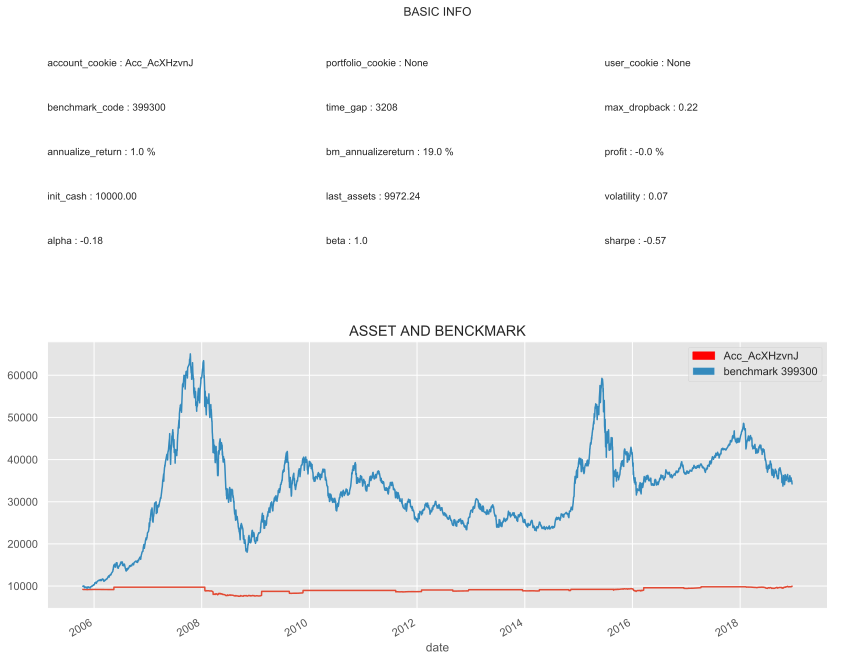

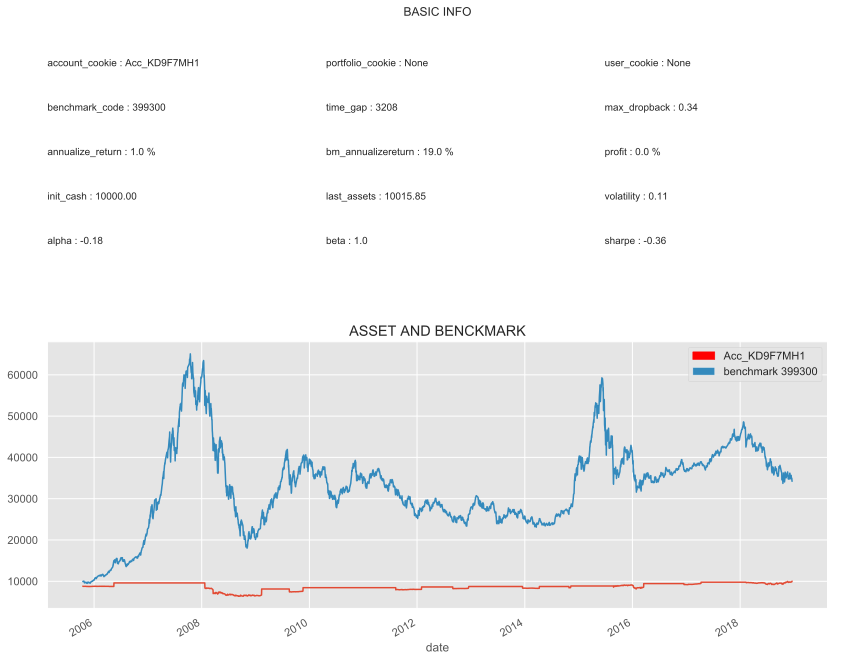

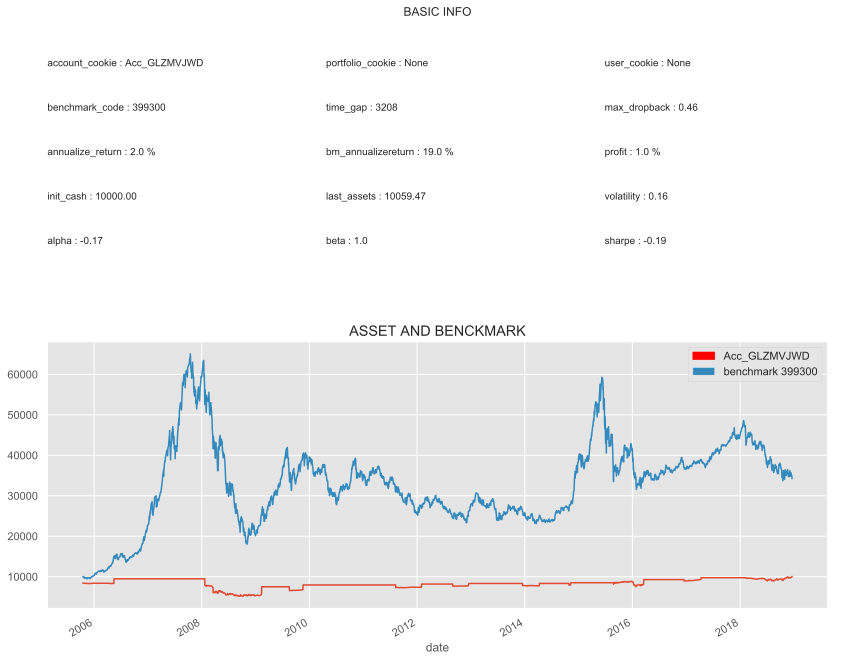

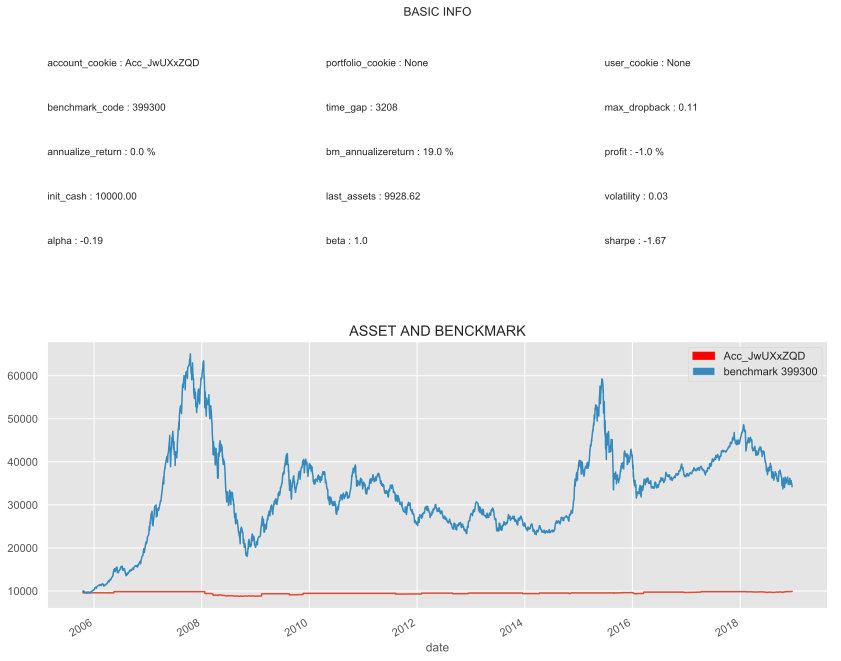

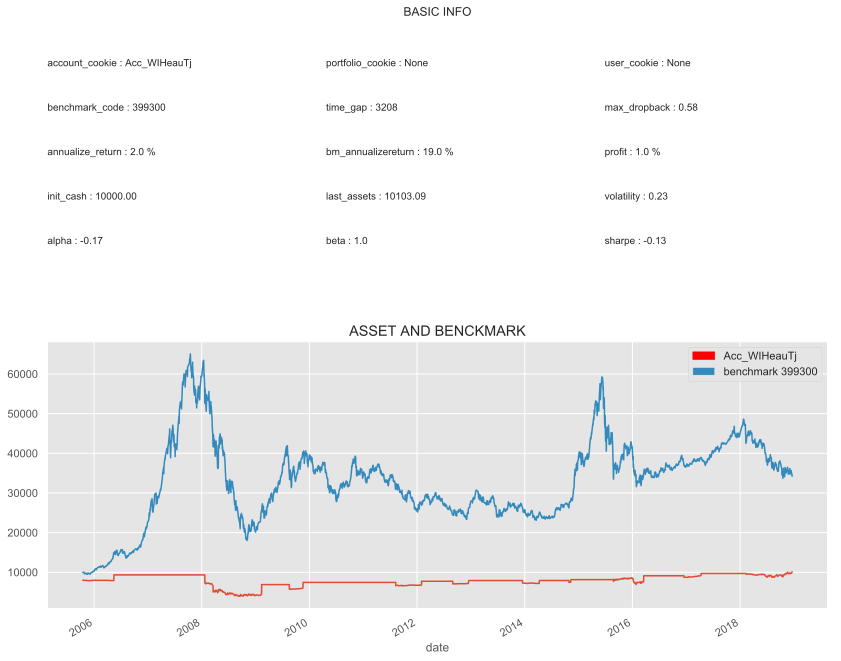

In [42]:
_plot_risk(d_std)

# 均值最大的10个

In [43]:
ysd_sr.sort_values('mean',ascending=False)[0:10]

,max,min,mean,std
code,,,,
000605,17.338131,-2.131381,1.456605,4.709920
600745,14.403512,-1.922585,1.281992,4.072452
600519,4.781666,-1.447703,1.127921,1.684034
000895,9.936704,-1.023082,1.122892,2.795773
000651,3.006778,-0.735689,1.106123,1.133413
600276,3.479829,-0.889863,1.073916,1.177566
600862,11.670479,-1.664807,1.038018,3.419266
600385,11.036210,-3.376465,1.007788,3.608263
600053,8.650080,-2.032802,0.948773,2.577741


<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUAN

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

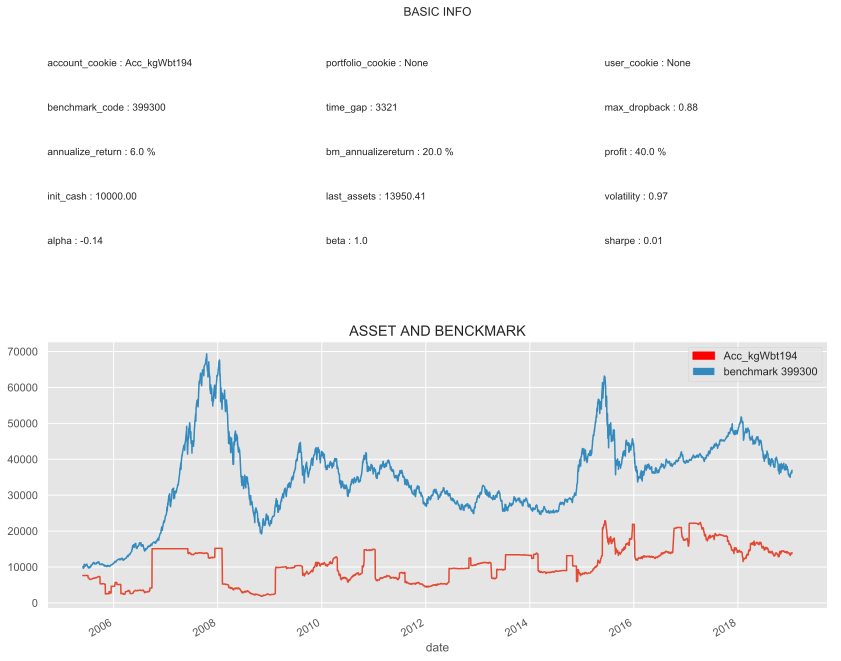

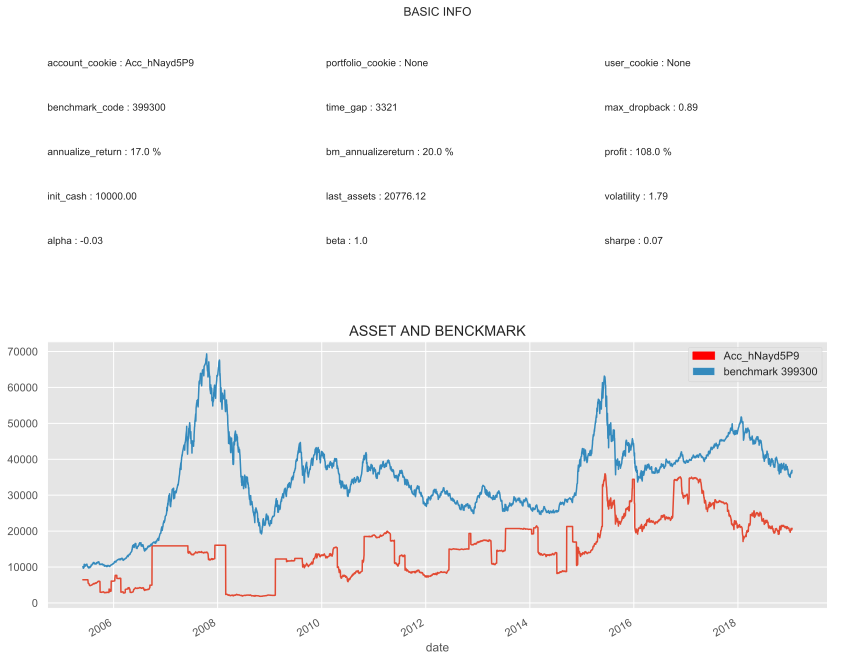

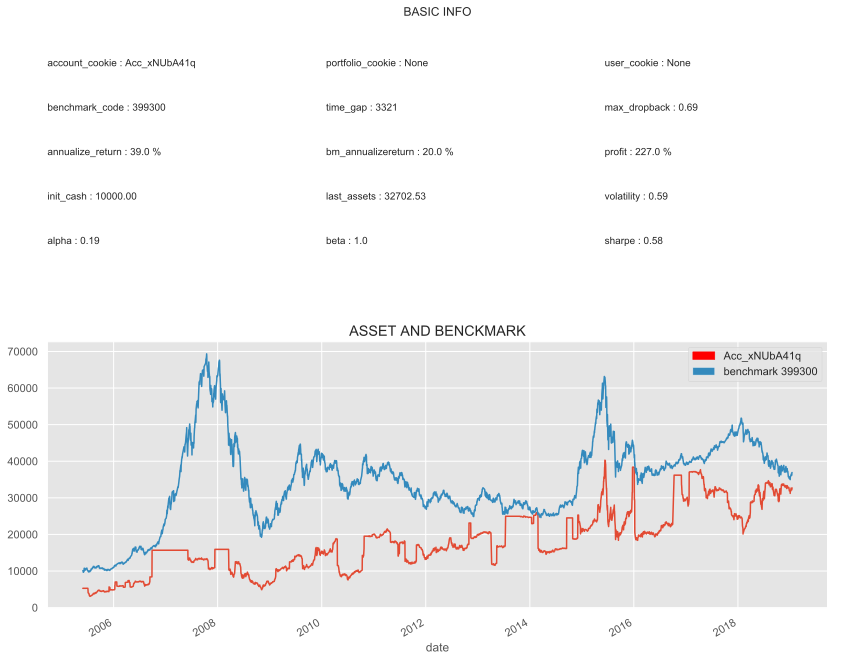

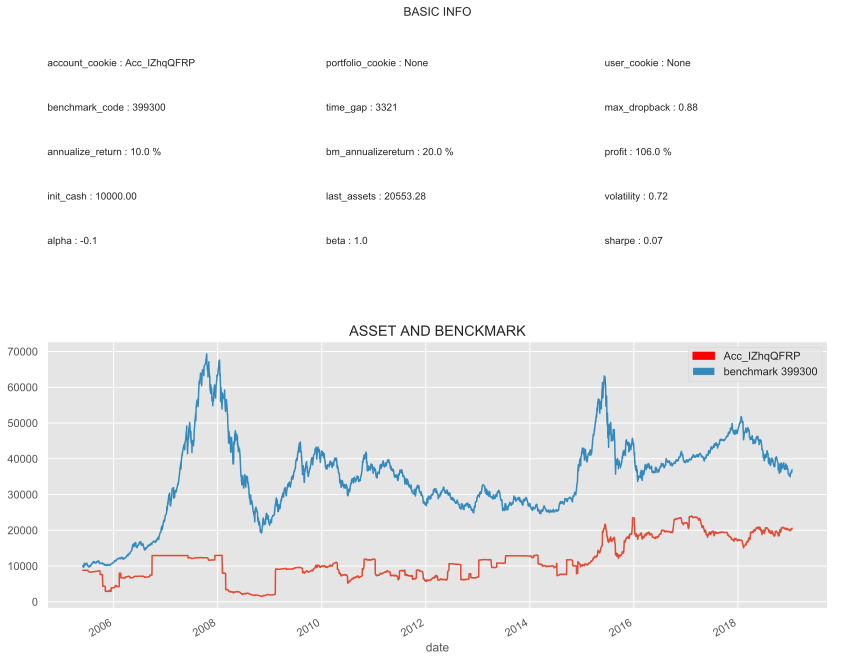

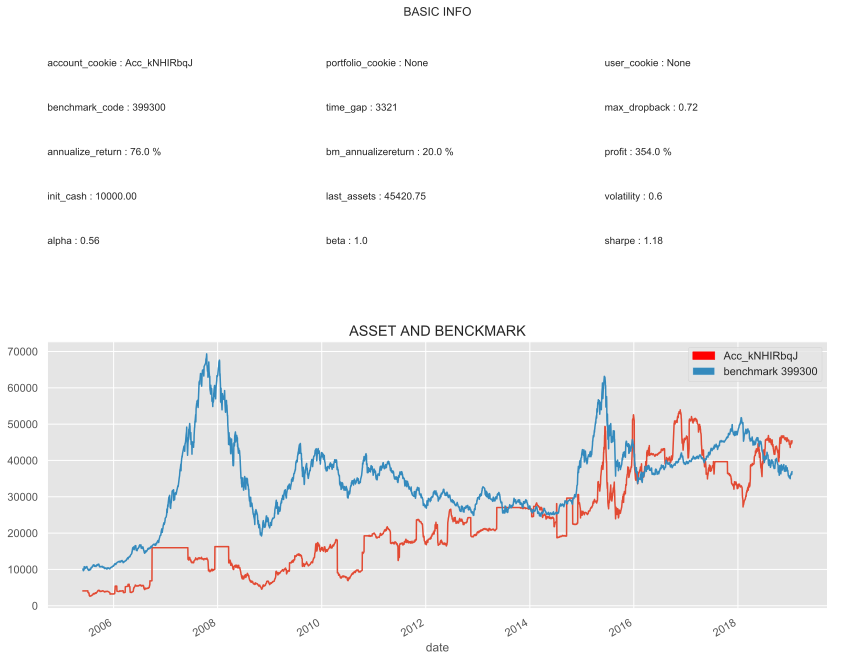

In [44]:
d_mean=_calc(ysd_sr.sort_values('mean',ascending=False)[0:10].index.tolist(),start_str,end_str)
_plot_risk(d_mean)

# 均值最大+标准差最小的10个

In [45]:
_sort_buy_std_and_mean(ysd_sr).sort_values('score')[0:10]

,order_std,order_mean,score
code,,,
600436,14,10,24
000538,53,20,73
600967,5,84,89
600867,68,25,93
600612,38,63,101
600588,45,66,111
600801,37,75,112
000963,106,16,122
000998,18,105,123


<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

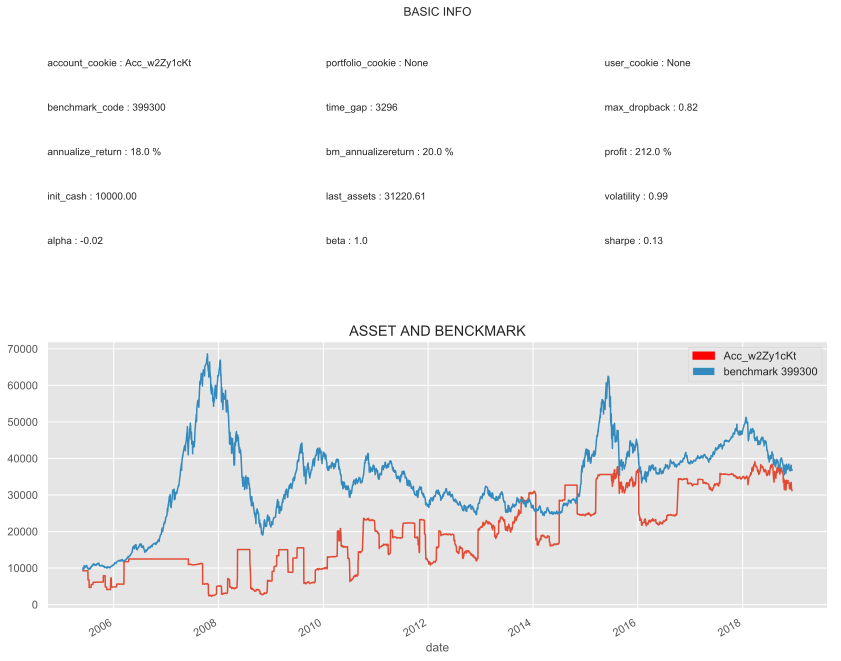

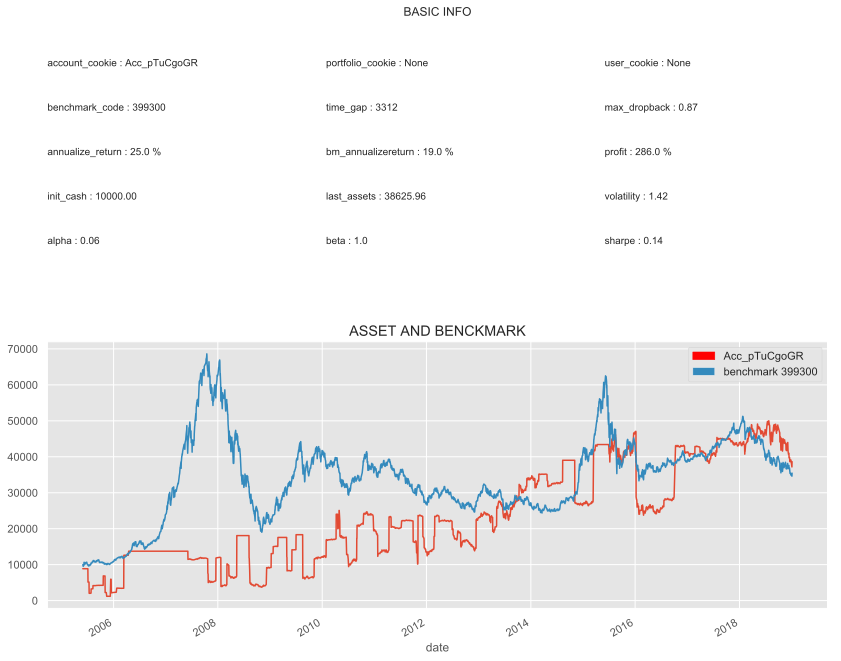

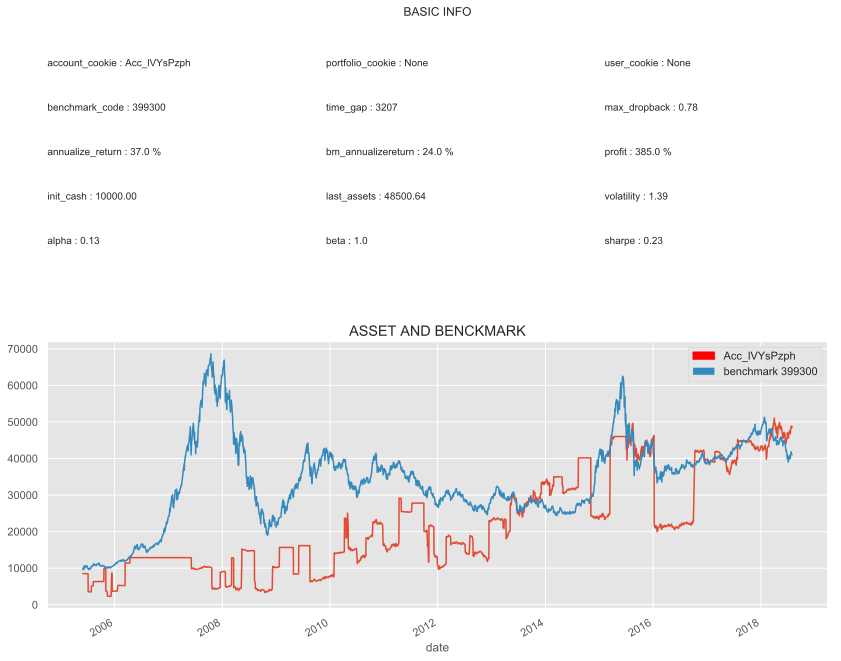

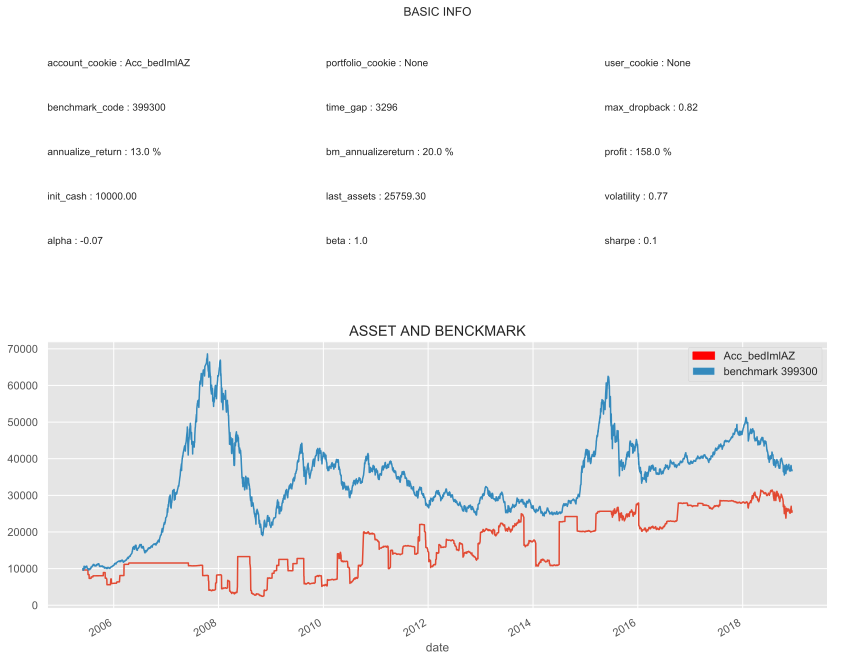

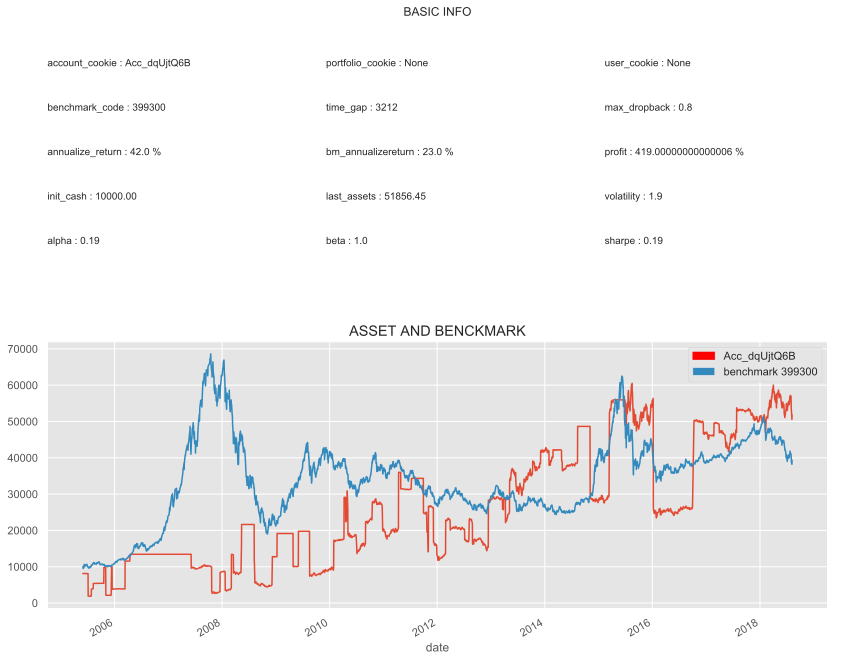

In [46]:
d_mean_std=_calc(_sort_buy_std_and_mean(ysd_sr).sort_values('score')[0:10].index.tolist(),start_str,end_str)
_plot_risk(d_mean_std)